# Part 1 - Exploratory Data Analysis

**Loading relevant packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

**Loading data and sorting by login time**

In [2]:
file_path = 'logins.json'
logins = pd.read_json(file_path).sort_values(by='login_time').reset_index(drop=True)

**Floring the data series by 15-minute intervals**

In [3]:
logins['login_time_15_min'] = logins['login_time'].dt.floor(freq='15T')

In [4]:
logins

,login_time,login_time_15_min
0,1970-01-01 20:12:16,1970-01-01 20:00:00
1,1970-01-01 20:13:18,1970-01-01 20:00:00
2,1970-01-01 20:16:10,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:16:37,1970-01-01 20:15:00
...,...,...
93137,1970-04-13 18:48:52,1970-04-13 18:45:00
93138,1970-04-13 18:50:19,1970-04-13 18:45:00
93139,1970-04-13 18:54:02,1970-04-13 18:45:00
93140,1970-04-13 18:54:23,1970-04-13 18:45:00


**Group by the 15-min intervals to make a time series of number of logins per 15-minute interval**

In [5]:
time_series = logins.groupby('login_time_15_min')['login_time_15_min'].count().rename('logins_num')
time_series

login_time_15_min
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Name: logins_num, Length: 9381, dtype: int64

**Plotting the resulting time series**  
The time interval is too small to draw any meaningful insights when plotted like this. This will be addressed later.

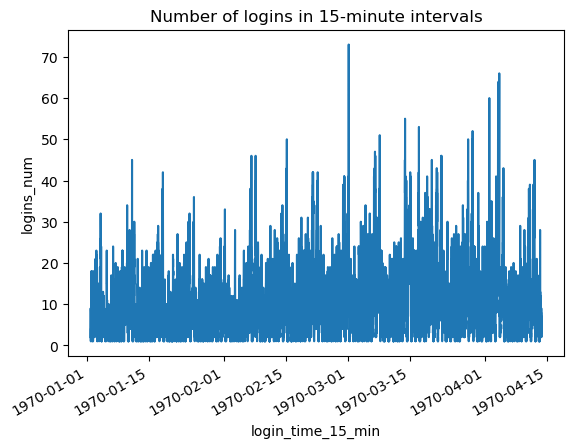

In [6]:
time_series.plot()
plt.ylabel('logins_num')
plt.title('Number of logins in 15-minute intervals')
plt.show()

# Monthly Trends

The following plots show the time series of the number of logins for each month. It is not very smooth though, so it is hard to see if there are any seasonal patterns.

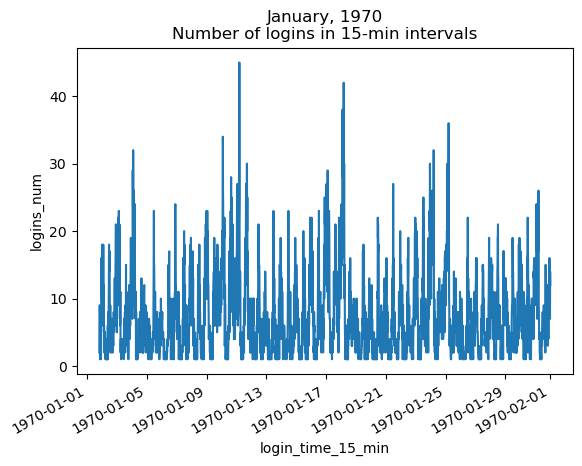

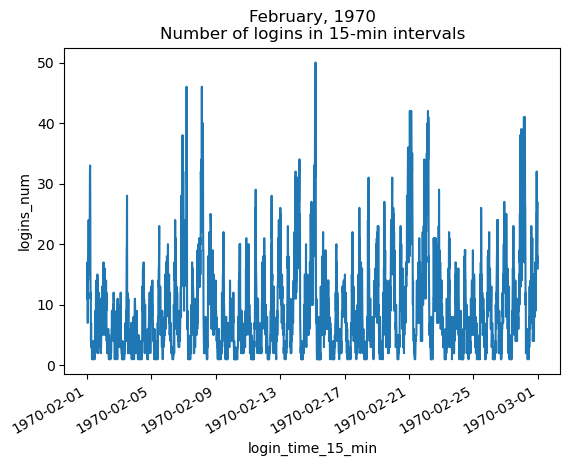

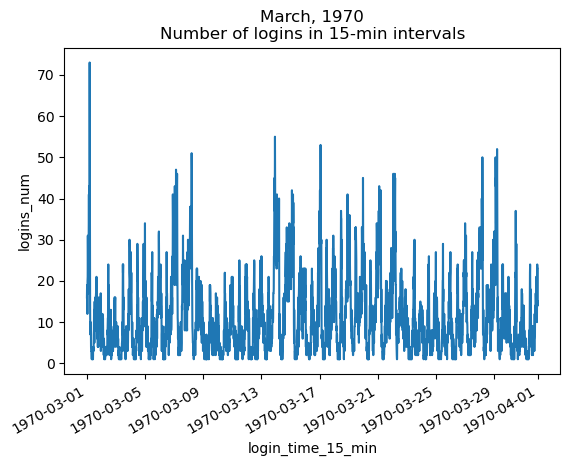

In [7]:
for month in range(1, 4):
    start = pd.Timestamp(1970, month, 1)
    end = pd.Timestamp(1970, month + 1, 1)
    time_series[start:end].plot()
    plt.ylabel('logins_num')
    plt.title(start.month_name() + ', ' + str(start.year) + '\nNumber of logins in 15-min intervals')
    plt.show()

We, therefore, do a 1-day moving average.

The graphs show that the data exhibits seasonality. The width of each peak is about one week long, so I speculate that perhaps the number of logins goes down during the weekends. We will verify this in the next graphs where the series will be plotted per week.

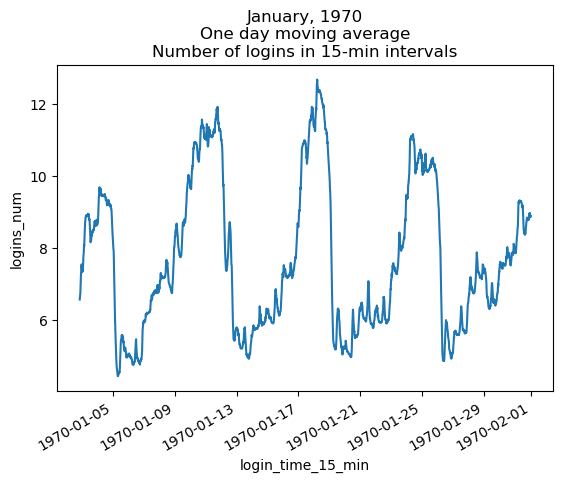

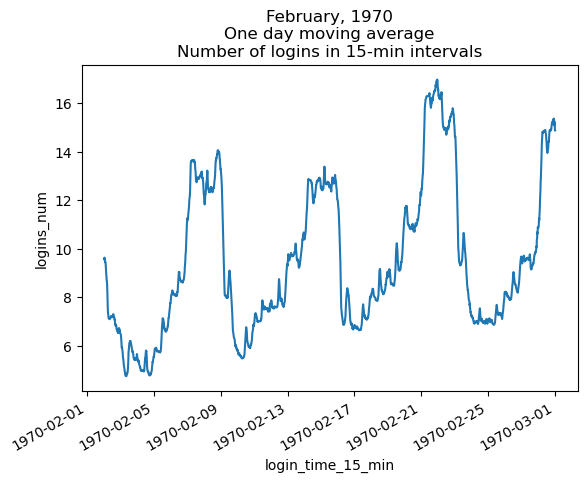

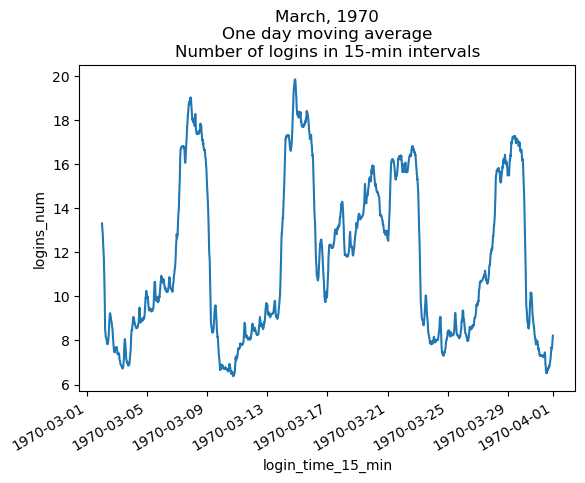

In [8]:
for month in range(1, 4):
    start = pd.Timestamp(1970, month, 1)
    end = pd.Timestamp(1970, month + 1, 1)
    time_series[start:end].rolling(window=96).mean().plot()
    plt.ylabel('logins_num')
    plt.title(start.month_name() + ', ' + str(start.year) + '\nOne day moving average' + '\nNumber of logins in 15-min intervals')
    plt.show()

# Weekly Trends

Each of the following graphs shows the time series of the number of logins for a single day. Only the days in the month of January 1970 are shown, but the trends are similar for the other months.

During the weekdays, the data usually has three peaks: one during the early morning (from about 12:00 am to 3:00 am), one in the middle of the day (from about 12:00 pm to 3:00 pm), and one during the evening (from about 9:00 pm to 12:00 am). The trend is different during the weekends, where often you would see the peak that happens during the early morning, but then the number of logins flattens to a low value that lasts for the rest of the day.

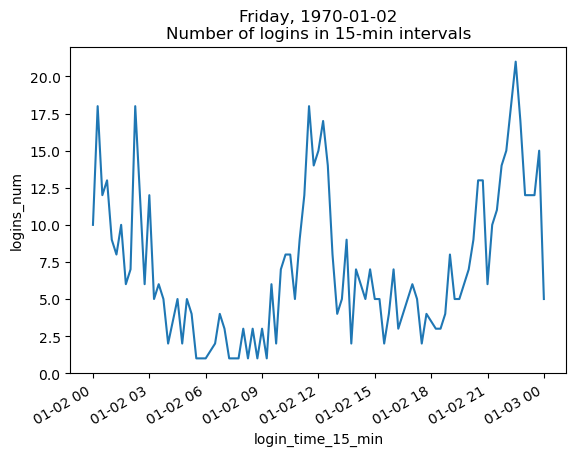

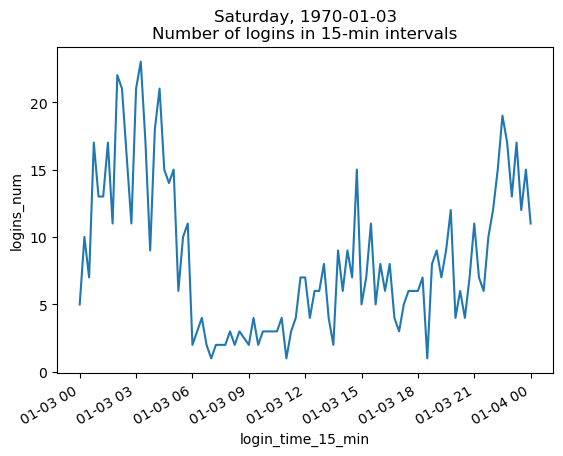

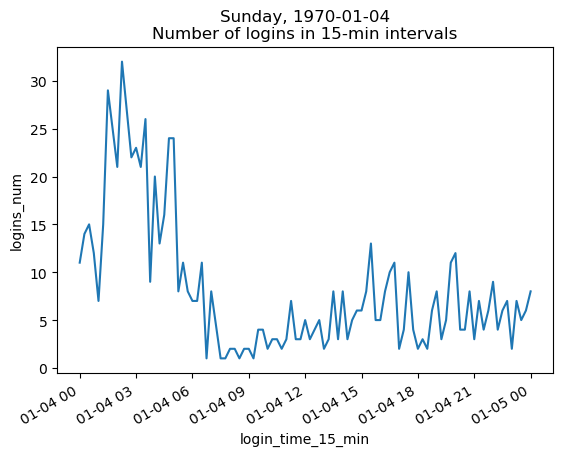

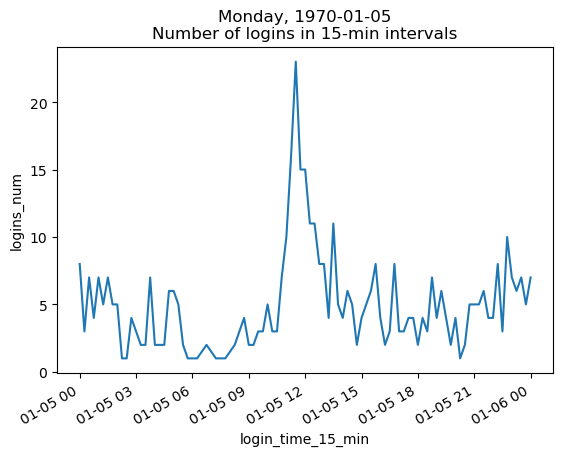

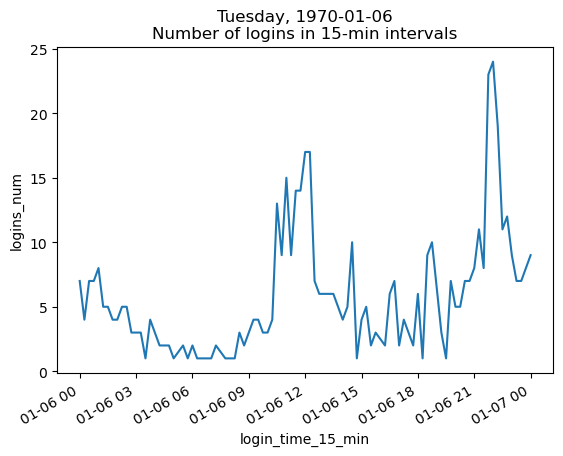

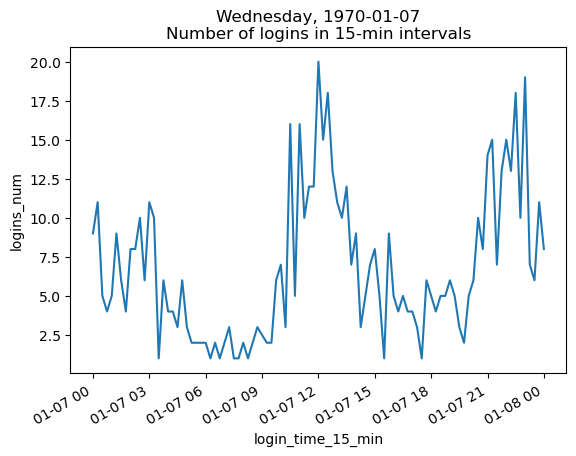

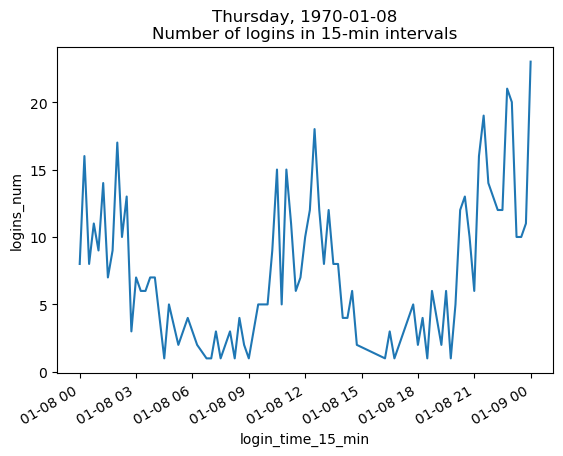

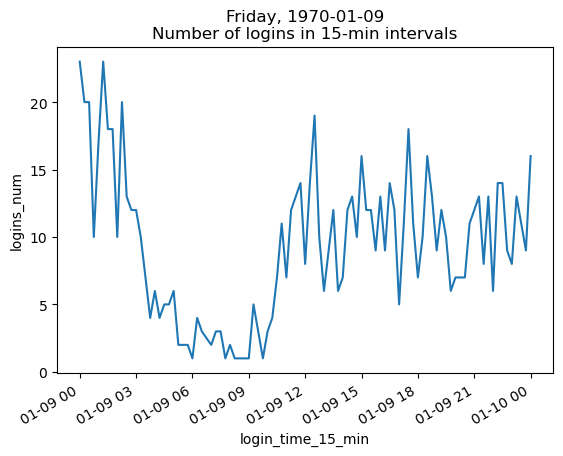

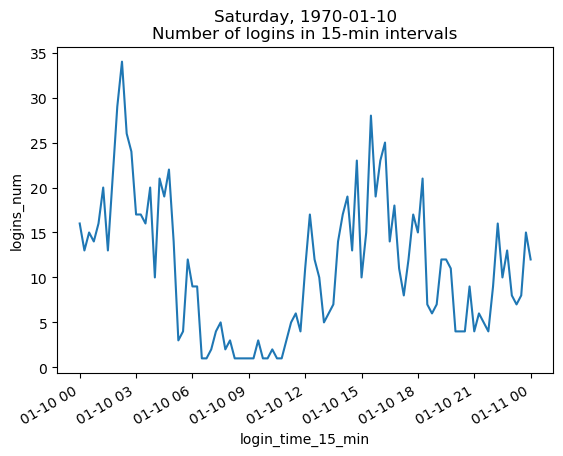

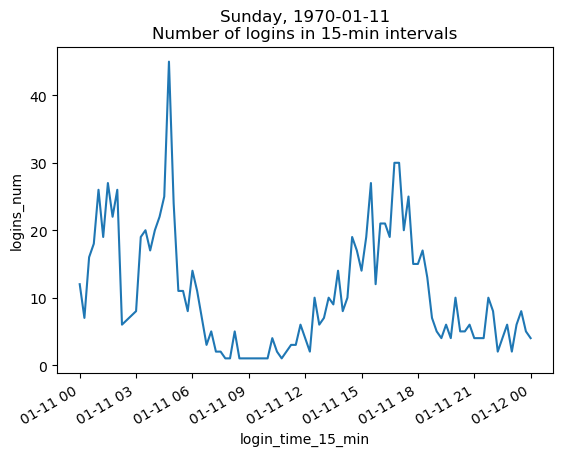

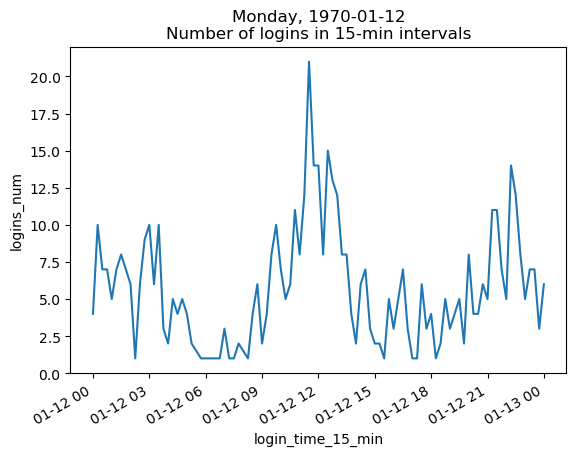

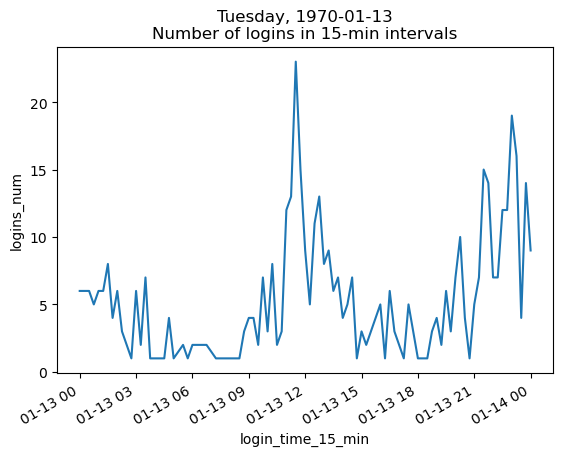

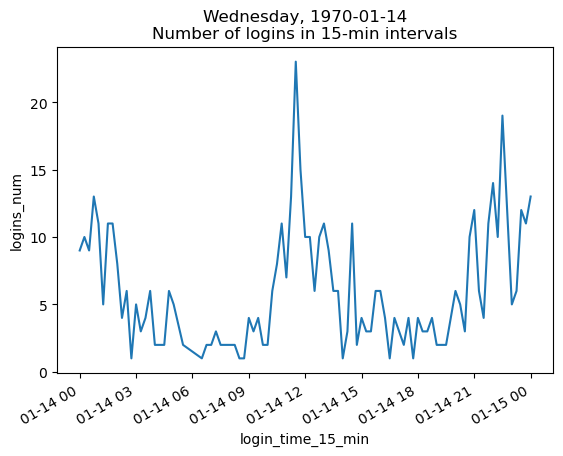

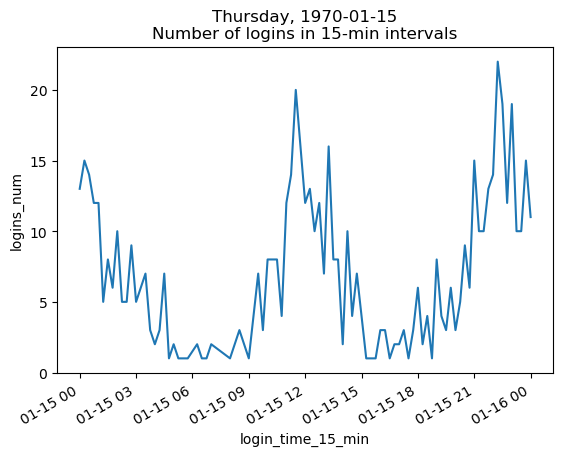

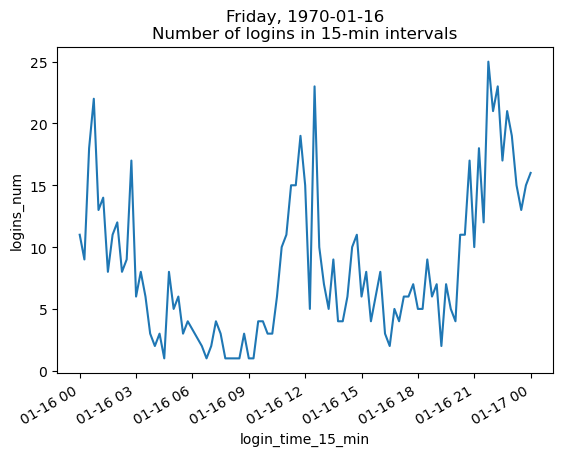

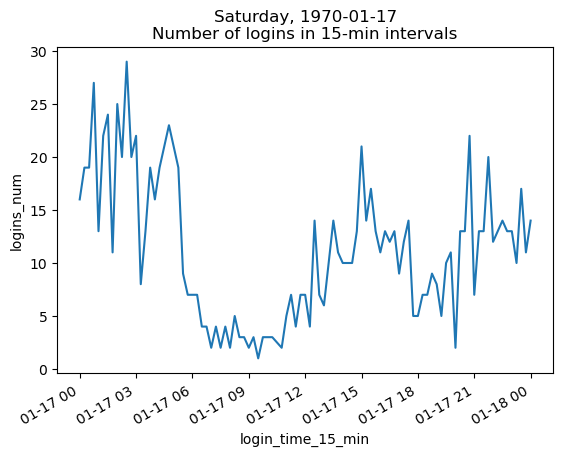

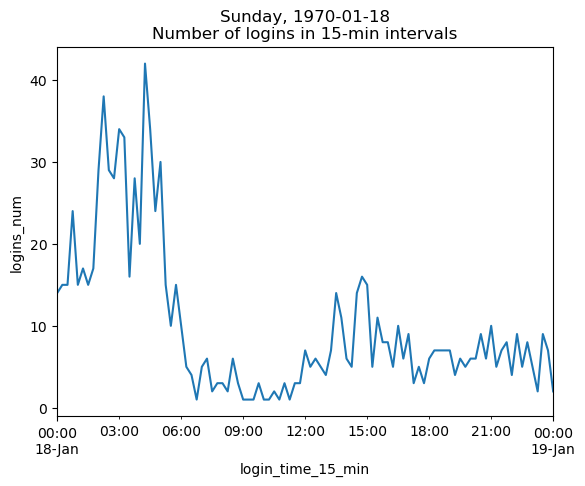

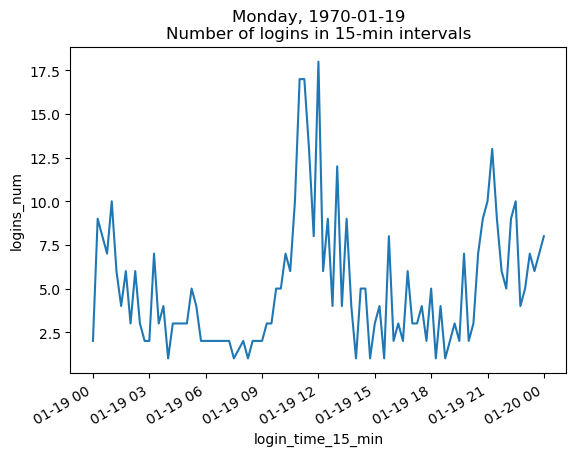

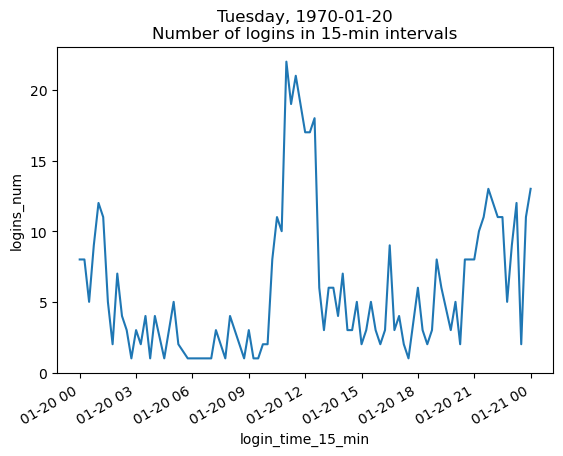

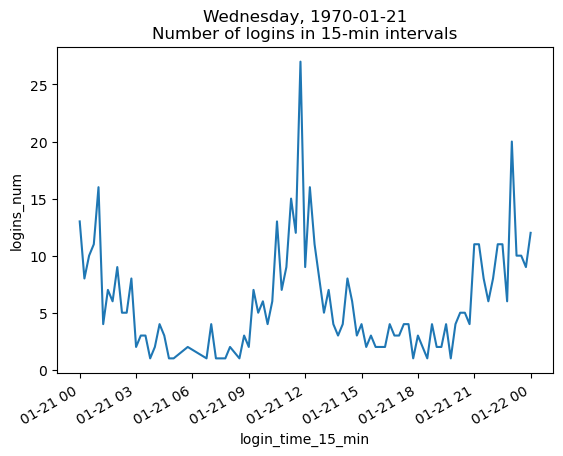

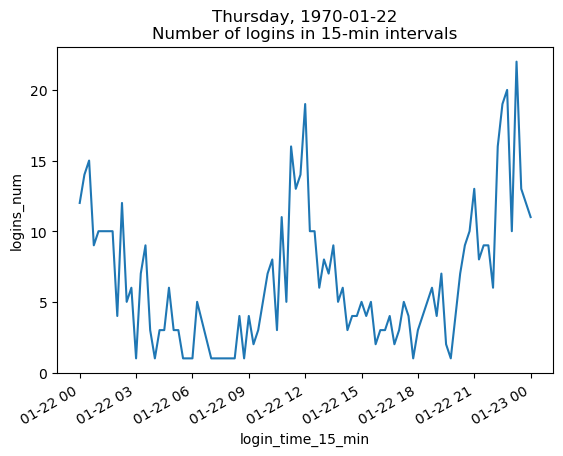

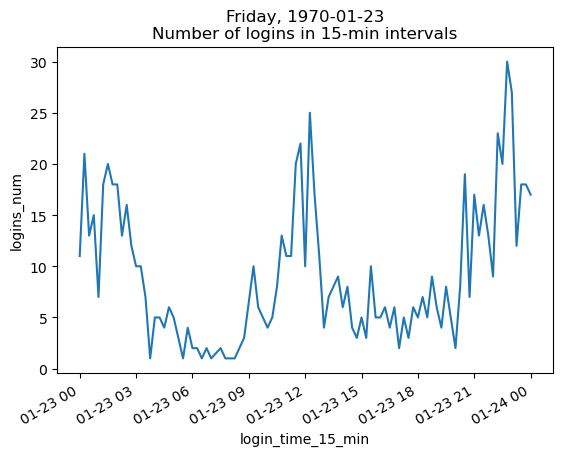

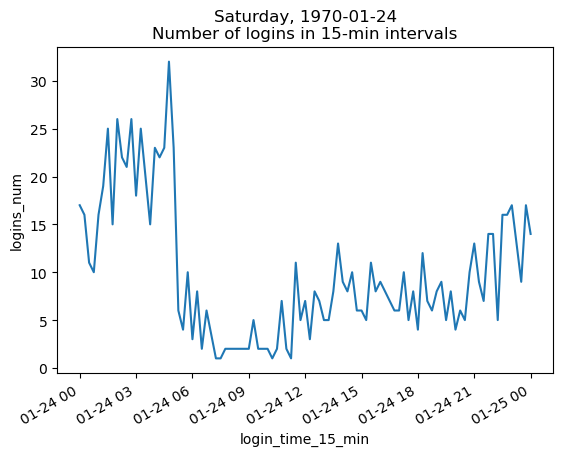

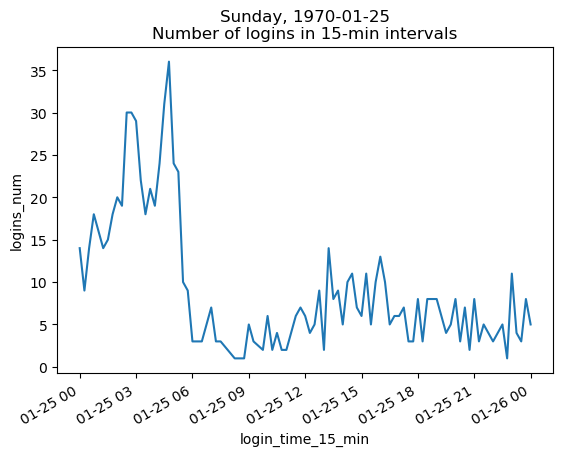

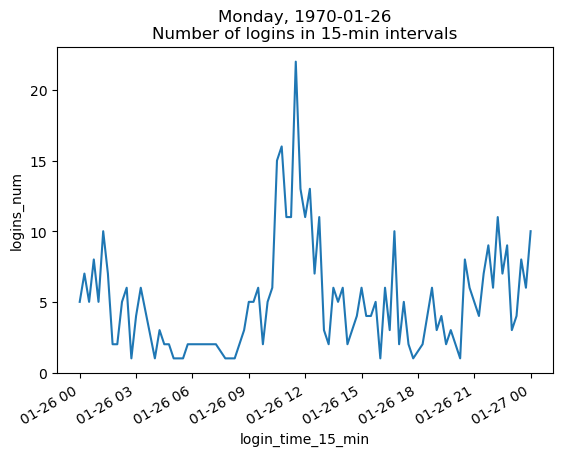

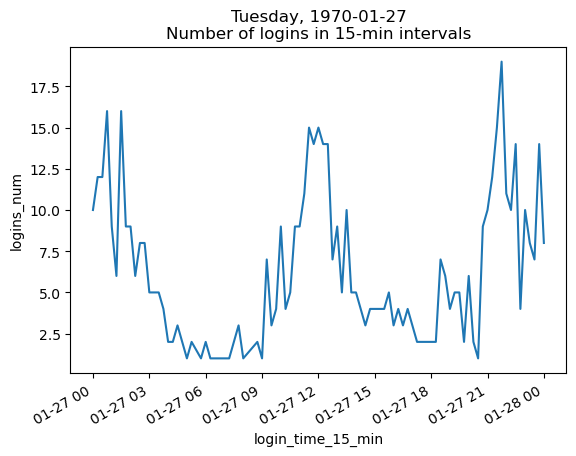

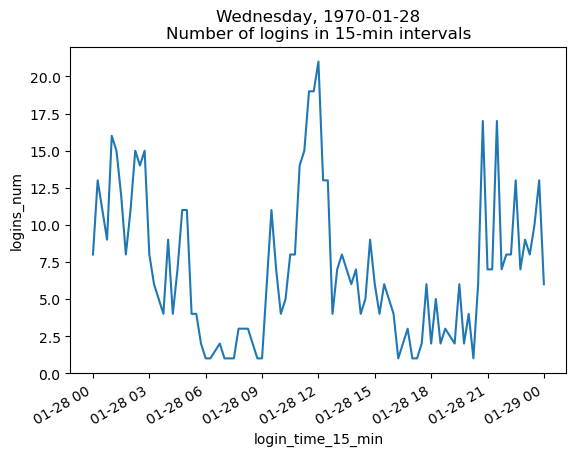

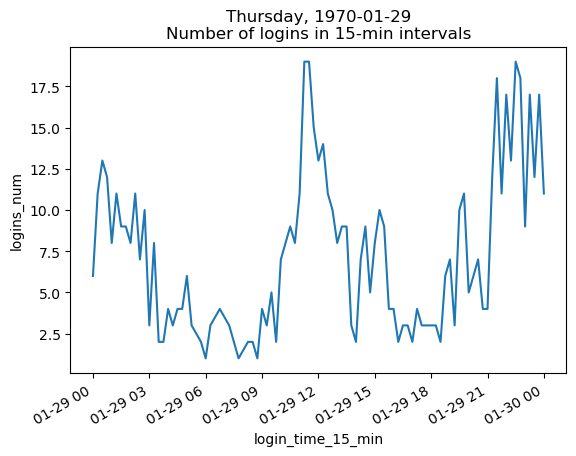

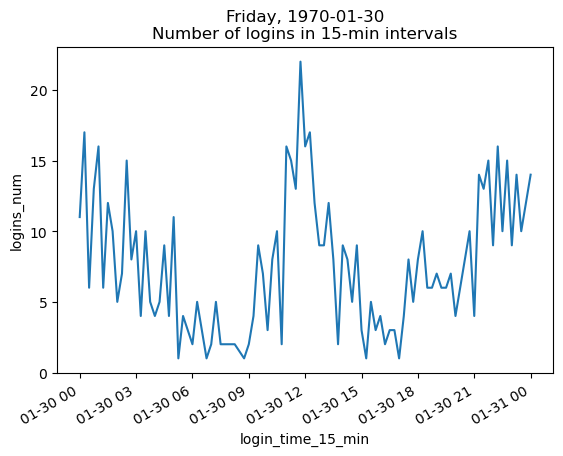

In [9]:
month = 1 #January
for day in range(2, 31): #First day not included due to insufficient data
    try:
        start = pd.Timestamp(1970, month, day)
        end = pd.Timestamp(1970, month, day + 1)
    except ValueError:
        print(f'Month {month} and day {day} are out of range.')
        continue
    time_series[start:end].plot()
    plt.ylabel('logins_num')
    plt.title(start.day_name() + ', ' + str(start.date()) + '\nNumber of logins in 15-min intervals')
    plt.show()

# Part 2 - Experient and Metric Design

Please refer to the project instructions pdf file for the problem description.

## Step 1: Categorizing the Driving Partners
The first step is to categorize all driving partners as either "Gotham or "Metropolis" partners. This is not meant to imply that they operate exclusively in those areas, but rather that a high proportion of their business is conducted in the respective region. To categorize them, we need to collect, for each driving partner operating in all cities, information on each time they provided a service to a customer (from here on known as "services"). For each of these services, the relevant information that we need is in which of the two cities was it provided. For each driving partner, if the proportion of their services provided in one of these two cities goes above a predetermined threshold, then we categorize the partner as being a partner of that city. For example, if more than 80% of the business of a driving partner was conducted in Gotham, we categorize it as being a "Gotham Partner".

## Step 2: Defining the Metric of Success
The second step is to define the metric of success, which I will call the "number of off-city services per day". An off-city service is defined as one that happens in the "other city". Therefore, if a partner that was categorized as a "Gotham Partner" conducts business in Metropolis, we consider that instance to be an off-city service. This works as a metric because the number will be relatively low when the driving partners are discouraged to operate in the "other city" (due to the toll on the bridge that connects the cities); otherwise, it will be bigger. 

## Step 3: Collect Data Before and After the Toll Reimbursement Policy is Implemented
The third step is to collect data on the services that they provide during a predetermined time interval under two conditions: before the toll reimbursement policy is implemented, and after it is implemented. For example, for each driving partner, data can be collected on all of the services that they provided during a time period (for example, one month) before the toll reimbursement policy is implemented, and again for a period of time after the policy is implemented. 

## Step 4: Conduct Hypothesis Test
The fourth step is to find, for each day, the number of off-city services per day. If the toll reimbursement policy works, we expect the average of these numbers to be statistically different before the policy is implemented and after. Therefore, we can use a hypothesis test for the difference between those means. If the difference in the mean is statistically different from zero (the null hypothesis), then we can reject the hypothesis that implementing the policy will not lead to a significant change in the average number of off-city services per day. 

# Part 3 - Predictive Modeling

## 3.1 - Loading Data

In [10]:
file_path_2 = 'ultimate_data_challenge.json' 
data = pd.read_json(file_path_2)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## 3.2 - Exploratory Data Analysis

**Changing date features dtype from object to datetime. This will be useful when plotting histograms**

In [12]:
data[['signup_date', 'last_trip_date']] = data[['signup_date', 'last_trip_date']].apply(lambda ser: pd.to_datetime(ser))

In [13]:
import seaborn as sns

### 3.2.1 - Catplots

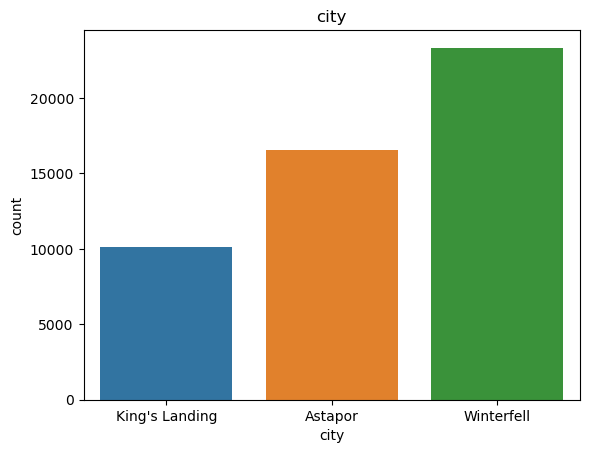

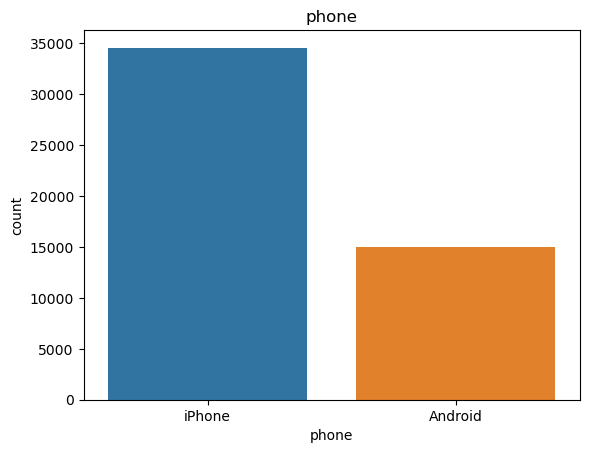

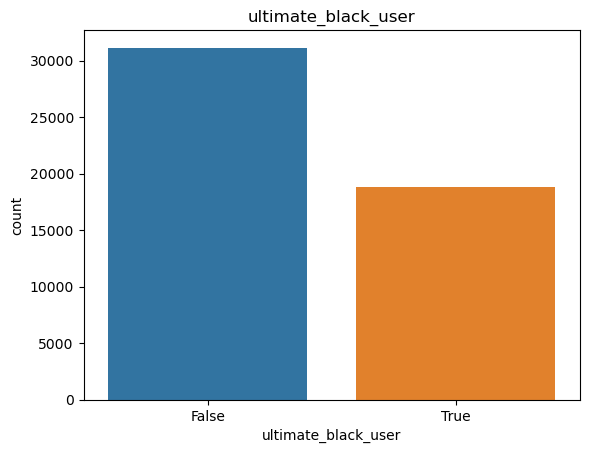

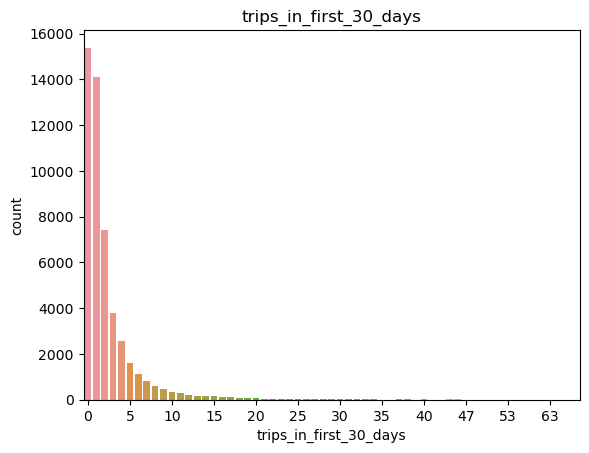

In [14]:
categorical_features = ['city', 'phone', 'ultimate_black_user', 'trips_in_first_30_days']
for column in categorical_features:
    sns.countplot(data=data, x=column)
    plt.title(column)
    if column == 'trips_in_first_30_days':
        plt.xticks(range(0, 60, 5))
    plt.show()

### 3.2.2 - Histograms

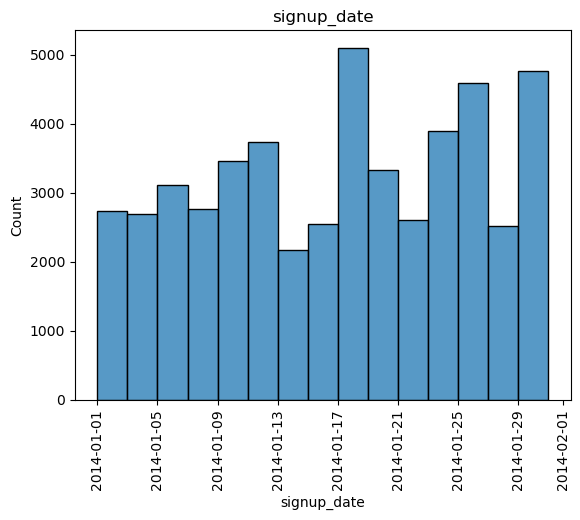

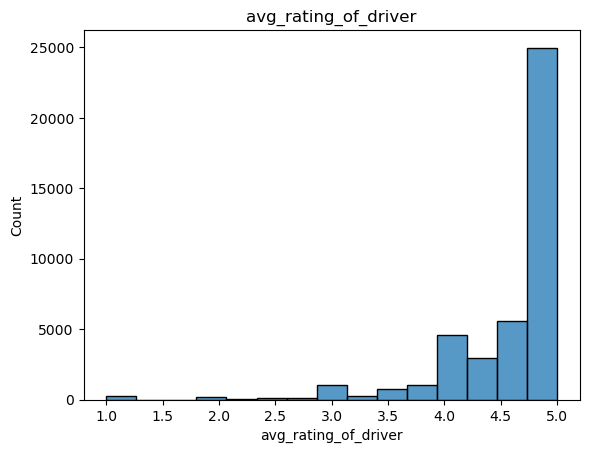

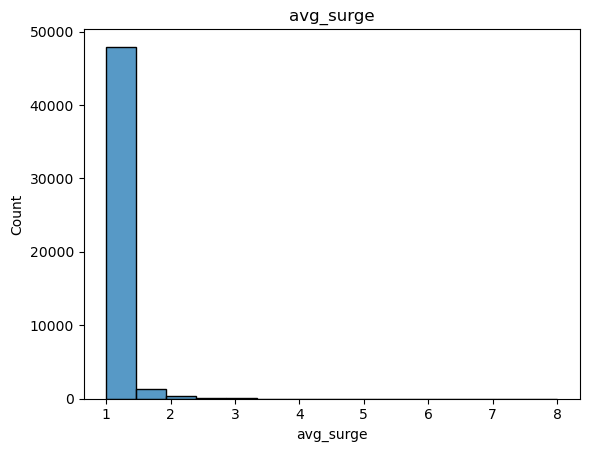

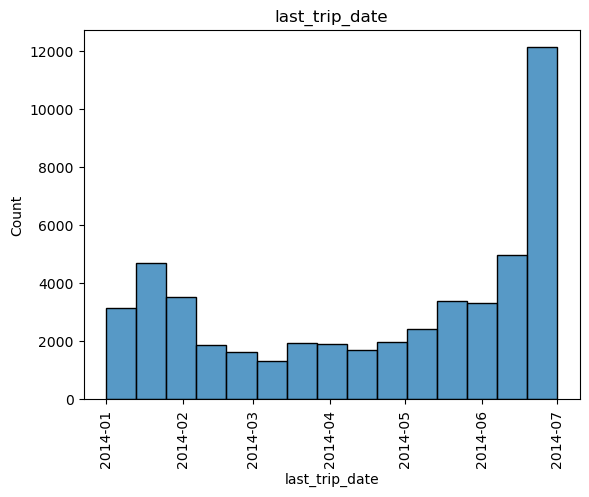

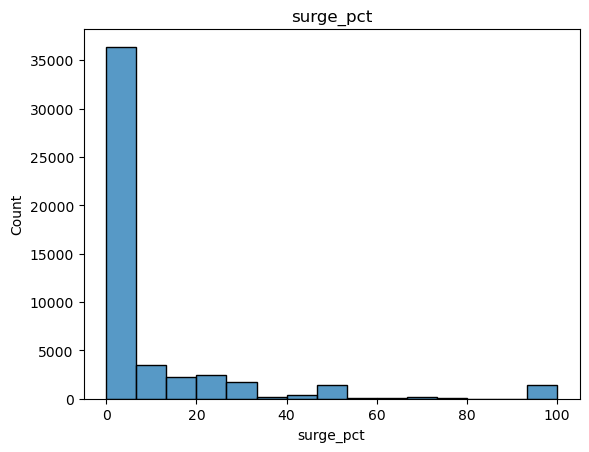

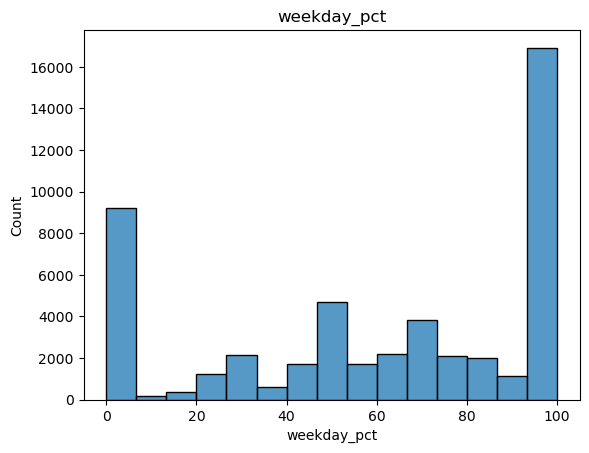

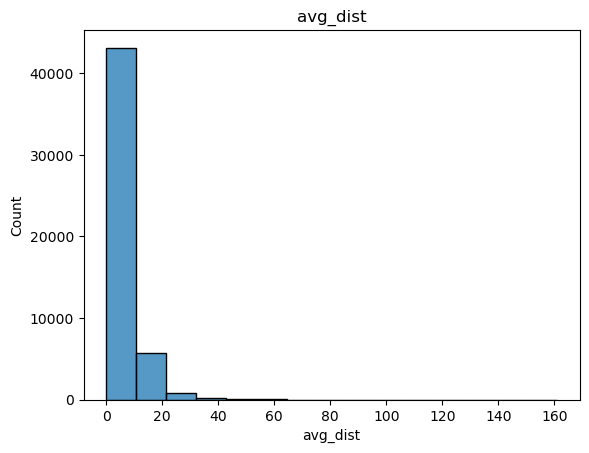

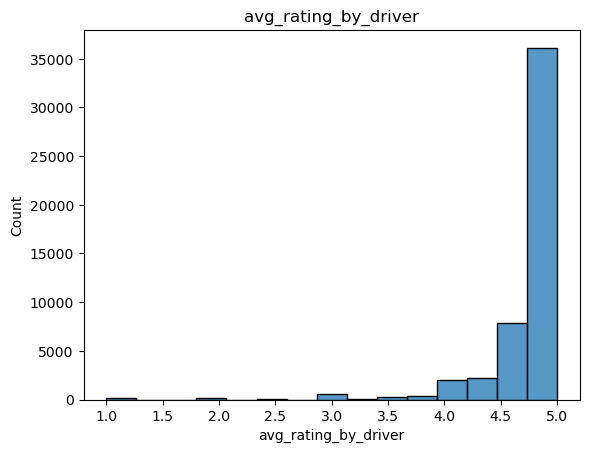

In [15]:
for column in [col for col in data.columns if col not in categorical_features]:
    sns.histplot(data=data, x=column, bins=15)
    plt.title(column)
    if column in ['signup_date', 'last_trip_date']:
        plt.xticks(rotation=90)
    plt.show()

## 3.3 - Preprocessing

### 3.3.1 - Missing Values

**Three columns contain missing values. Checking the percentage or rows with missing values for a given column.**

In [16]:
nrows = data.shape[0]
print('Percentage of rows with missing values for given column:')
for column in ['avg_rating_of_driver', 'phone', 'avg_rating_by_driver']:
    print(f'{column}: {data[column].isnull().sum() / data.shape[0] * 100:0.1f}%')

Percentage of rows with missing values for given column:
avg_rating_of_driver: 16.2%
phone: 0.8%
avg_rating_by_driver: 0.4%


I decided to drop the rows containing missing values for the feature `phone` because its percentage of missing values is low. As we will see soon, these coincide with the missing values for `avg_rating_by_driver`, so those will also be dropped. We will impute values later for `avg_rating_of_driver`.

In [17]:
data = data.dropna(subset='phone').reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    41578 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### 3.3.2 - Defining the Target Feature

The date the data was pulled is not provided, but it is reasonable to assume that some people used the services during the last day of data collection. Therefore, the latest value in the feature `last_trip_day` will be used as the last day of data collection. 

**Finding last date**

In [18]:
last_date = data['last_trip_date'].sort_values(ascending=False).reset_index(drop=True)[0]
last_date

Timestamp('2014-07-01 00:00:00')

**Defining feature `n_days_ago_last_trip`**  
This is defined as how many days ago from the last day of data collection did a customer use the service.

In [19]:
data['n_days_ago_last_trip'] = (last_date - data['last_trip_date']).dt.days
data['n_days_ago_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49599     26
49600    157
49601     40
49602    167
49603     72
Name: n_days_ago_last_trip, Length: 49604, dtype: int64

**Histogram of `n_days_ago_last_trip`**  
The vertical line shows the cutoff under which the customer is considered "retained".

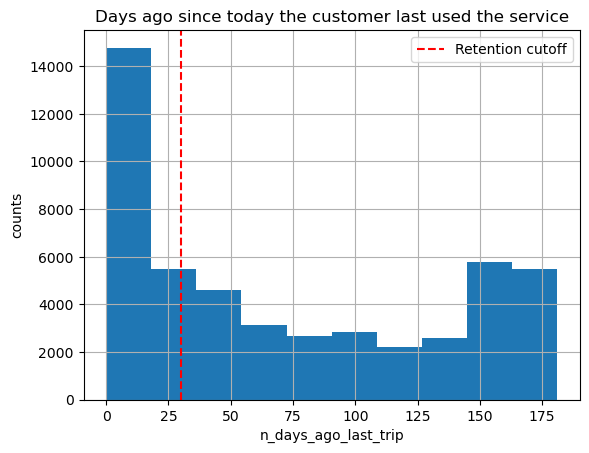

In [20]:
data['n_days_ago_last_trip'].hist()
plt.axvline(x=30, ls='--', color='r', label='Retention cutoff')
plt.legend()
plt.xlabel('n_days_ago_last_trip')
plt.ylabel('counts')
plt.title('Days ago since today the customer last used the service')
plt.show()

**Defining target feature**

In [21]:
data['retained'] = (data['n_days_ago_last_trip'] <= 30).astype('int')
data['retained']

0        1
1        0
2        0
3        1
4        0
        ..
49599    1
49600    0
49601    0
49602    0
49603    0
Name: retained, Length: 49604, dtype: int64

**Finding proportion of customers considered "retained"**  
The data seems to be slightly imbalanced.

In [22]:
retained_counts = data.groupby('retained')['retained'].count().rename(index={False:'No', True:'Yes'}).rename('retained_counts').rename_axis(None)
retained_counts

No     30933
Yes    18671
Name: retained_counts, dtype: int64

In [23]:
total = retained_counts.sum()
not_retained_pct = retained_counts['No'] / total * 100
retained_pct = retained_counts['Yes'] / total * 100
print(f'Percentages\nNot Retained: {not_retained_pct:0.1f}%\nRetained: {retained_pct:0.1f}%')

Percentages
Not Retained: 62.4%
Retained: 37.6%


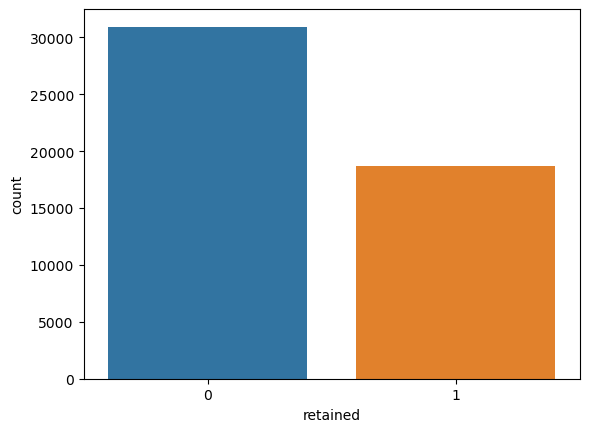

In [24]:
sns.countplot(data=data, x='retained')
plt.show()

### 3.3.3 - Changing dtypes  
Some machine learning algorithms can only work with int and float dtypes. We will therefore change the dtypes of features that are not one of these.

**Finding columns whose dtype needs changing**

In [25]:
for column in data.select_dtypes(include=['object', 'datetime']).columns:
    print(column)

city
signup_date
last_trip_date
phone


**Changing dtype of datetimes**  
Datetime objects will be changed to an integer representing the day since the start of the data collection date.

In [26]:
first_date = data['last_trip_date'].sort_values(ascending=True).reset_index(drop=True)[0]
first_date
data['signup_date_int'] = (data['signup_date'] - first_date).dt.days
data['last_trip_date_int'] = (data['last_trip_date'] - first_date).dt.days

**Using label encoder for object dtypes**

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for column in ['city', 'phone']:
    data[column] = pd.Series(le.fit_transform(data[column]))

**Changing bool type to int**

In [28]:
data['ultimate_black_user'] = data['ultimate_black_user'].astype('int')

### 3.3.4 - Defining feature matrix and target vector  
Note that the feature `last_trip_date_int` is redundant with the target, `retained`. We therefore have to drop this feature.

In [29]:
X = data.drop(columns=['signup_date', 'last_trip_date', 'n_days_ago_last_trip', 'retained', 'last_trip_date_int'])
y = data['retained']

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  int64  
 1   trips_in_first_30_days  49604 non-null  int64  
 2   avg_rating_of_driver    41578 non-null  float64
 3   avg_surge               49604 non-null  float64
 4   phone                   49604 non-null  int64  
 5   surge_pct               49604 non-null  float64
 6   ultimate_black_user     49604 non-null  int64  
 7   weekday_pct             49604 non-null  float64
 8   avg_dist                49604 non-null  float64
 9   avg_rating_by_driver    49406 non-null  float64
 10  signup_date_int         49604 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 4.2 MB


In [31]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 49604 entries, 0 to 49603
Series name: retained
Non-Null Count  Dtype
--------------  -----
49604 non-null  int64
dtypes: int64(1)
memory usage: 387.7 KB


## 3.4 - Training

**Train-test split**

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

**Imputing feature `avg_rating_by_driver` with he median**  
The median was chosen because the feature's previously plotted histogram showed it was skewed. Care should always be taken to avoid data leakage.

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', copy=False).fit(X_train[['avg_rating_by_driver']])
X_train[['avg_rating_by_driver']] = imputer.transform(X_train[['avg_rating_by_driver']])
X_test[['avg_rating_by_driver']] = imputer.transform(X_test[['avg_rating_by_driver']])

**Training model using the XGBoost classifier algorithm**

In [34]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

## 3.5 - Model Evaluation  
We use scikit-learn's `classification_report` (precission, recall, f1-score, accuracy, etc) and are under roc curve to evaluate the model.

Based on the obtained scores for the training and test set, there doesn't seem to be evidence that the model is overfitting.

Classification report: training set
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     24746
           1       0.82      0.75      0.78     14937

    accuracy                           0.84     39683
   macro avg       0.84      0.82      0.83     39683
weighted avg       0.84      0.84      0.84     39683
 

Classification report: test set
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      6187
           1       0.74      0.67      0.70      3734

    accuracy                           0.79      9921
   macro avg       0.78      0.76      0.77      9921
weighted avg       0.78      0.79      0.78      9921



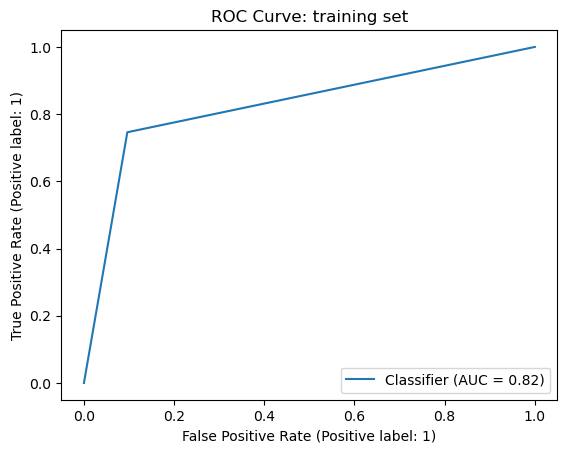

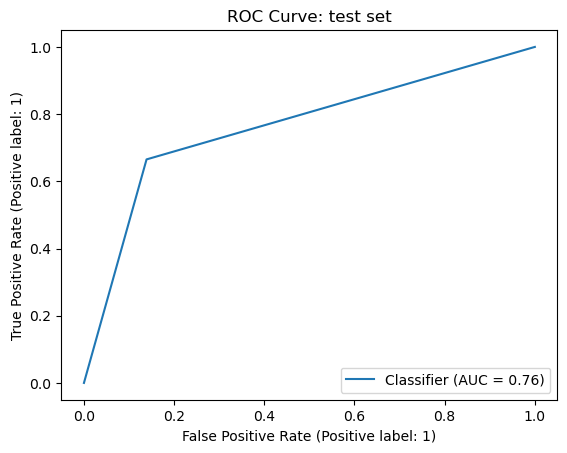

In [35]:
from sklearn.metrics import classification_report, RocCurveDisplay
print('Classification report: training set')
print(classification_report(y_train, y_train_pred), '\n')
print('Classification report: test set')
print(classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_train, y_train_pred)
plt.title('ROC Curve: training set')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title('ROC Curve: test set')
plt.show()

## 3.6 - Feature Importance

Note how `avg_dist` is considered, by far, the most important feature.

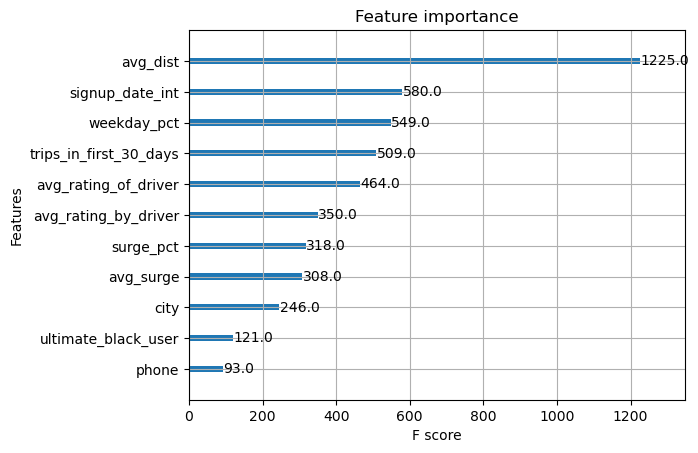

In [36]:
from xgboost import plot_importance

plot_importance(xgb)
plt.show()

## 3.7 - Final Remarks

We discovered from the data provided that only about 38% of the people who ever used the service were retained. We then used the data provided to build a machine learning model that can predict user retention using the XGBoost algorithm. The model performed well; for the test set, the model obtained an f1-score of 0.71 for the positive class and a roc auc score of 0.77. Only one model was built, so future research should be carried out to tweak the model to increase performance. We also found no evidence of overfitting based on the scores for the training and test sets; for example, the training and test set obtained f1-scores, respectively, of 0.78 and 0.71. 

We also used the resulting model to evaluate feature performance. By far the most important feature in predicting user retention is the average distance traveled by a user in the first 30 days. Therefore, if the user uses the service frequently from the very beginning, he or she is likely to be retained. 

It is very hard to find out what factors can lead a user to keep using the service just from a predictive model. However, since the model is able to predict which users are *not* likely to be retained, these predictions can be used to target them with measures aimed at incentivizing them to stay with the service. For example, individuals less likely to be retained can be offered more generous deals or promotions.